# Programming Assignment: 
## Готовим LDA по рецептам

В тематическом моделировании делается предположение о том, что для определения тематики порядок слов в документе не важен; об этом гласит гипотеза «мешка слов». Сегодня мы будем работать с несколько нестандартной для тематического моделирования коллекцией, которую можно назвать «мешком ингредиентов», потому что на состоит из рецептов блюд разных кухонь. Тематические модели ищут слова, которые часто вместе встречаются в документах, и составляют из них темы. Мы попробуем применить эту идею к рецептам и найти кулинарные «темы». Эта коллекция хороша тем, что не требует предобработки. Кроме того, эта задача достаточно наглядно иллюстрирует принцип работы тематических моделей.

Потребуются модули *json* и *gensim*. Первый входит в дистрибутив Anaconda, второй можно поставить командой 

*pip install gensim*

ПРИМЕЧАНИЕ: На ноутбуке с процессором Intel Core i7 и тактовой частотой 2400 МГц на построение одной модели уходит менее 10 минут.

### Загрузка данных

Коллекция дана в json-формате: для каждого рецепта известны его id, кухня (cuisine) и список ингредиентов, в него входящих. Загрузить данные можно с помощью модуля json (он входит в дистрибутив Anaconda):

In [2]:
import json

In [3]:
with open("recipes.json") as f:
    recipes = json.load(f)

In [4]:
print recipes[0]
print '\n', 'размер recipes =', len(recipes)

{u'cuisine': u'greek', u'id': 10259, u'ingredients': [u'romaine lettuce', u'black olives', u'grape tomatoes', u'garlic', u'pepper', u'purple onion', u'seasoning', u'garbanzo beans', u'feta cheese crumbles']}

размер recipes = 39774


### Составление корпуса

In [5]:
from gensim import corpora, models
import numpy as np

C:\ProgramData\Anaconda2\lib\site-packages\gensim\utils.py:865: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [6]:
import numpy
numpy.__version__

'1.11.3'

Коллекция небольшая, и целиком помещается в оперативную память. Gensim может работать с такими данными и не требует их сохранения на диск в специальном формате. Для этого коллекция должна быть представлена в виде списка списков, каждый внутренний список соответствует отдельному документу и состоит из его слов. Пример коллекции из двух документов: 

[["hello", "world"], ["programming", "in", "python"]]

Преобразуем наши данные в такой формат, а затем создадим объекты corpus и dictionary, с которыми будет работать модель.

In [7]:
texts = [recipe["ingredients"] for recipe in recipes]
dictionary = corpora.Dictionary(texts)   # составляем словарь
corpus = [dictionary.doc2bow(text) for text in texts]  # составляем корпус документов

In [8]:
print texts[0]
print corpus[0]

[u'romaine lettuce', u'black olives', u'grape tomatoes', u'garlic', u'pepper', u'purple onion', u'seasoning', u'garbanzo beans', u'feta cheese crumbles']
[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1)]


In [9]:
print dictionary

Dictionary(6714 unique tokens: [u'low-sodium fat-free chicken broth', u'sweetened coconut', u'baking chocolate', u'egg roll wrappers', u'bottled low sodium salsa']...)


In [10]:
for i in range(9):
    print dictionary[i]

pepper
seasoning
garbanzo beans
grape tomatoes
garlic
black olives
feta cheese crumbles
romaine lettuce
purple onion


In [11]:
for text in texts[0]:
    print dictionary.token2id[text]

7
5
3
4
0
8
1
2
6


In [12]:
print dictionary

Dictionary(6714 unique tokens: [u'low-sodium fat-free chicken broth', u'sweetened coconut', u'baking chocolate', u'egg roll wrappers', u'bottled low sodium salsa']...)


У объекта dictionary есть полезная переменная dictionary.token2id, позволяющая находить соответствие между ингредиентами и их индексами.

In [13]:
dictionary.token2id

{u'low-sodium fat-free chicken broth': 3067,
 u'sweetened coconut': 4351,
 u'baking chocolate': 4124,
 u'egg roll wrappers': 197,
 u'bottled low sodium salsa': 6280,
 u'vegan parmesan cheese': 1712,
 u'clam sauce': 5433,
 u'mahlab': 6168,
 u'(10 oz.) frozen chopped spinach, thawed and squeezed dry': 1988,
 u'figs': 1317,
 u'caramels': 3788,
 u'broiler': 3467,
 u'jalapeno chilies': 58,
 u'(15 oz.) refried beans': 5108,
 u'brioche buns': 5186,
 u'broccoli romanesco': 5876,
 u'flaked oats': 5838,
 u'anise extract': 2055,
 u'whole wheat pastry flour': 2193,
 u'ravva': 1403,
 u'bacon': 208,
 u'millet': 3209,
 u'country crock honey spread': 4572,
 u'matcha green tea powder': 326,
 u'chopped fresh thyme': 674,
 u'chicken gravy mix': 4786,
 u'walnut oil': 3608,
 u'Kraft Slim Cut Mozzarella Cheese Slices': 6704,
 u'fresh angel hair': 3628,
 u'salsify': 2726,
 u'galangal': 911,
 u'chicken schmaltz': 2331,
 u'butter crackers': 1469,
 u'jasmine': 2030,
 u'Bisquick Baking Mix': 3920,
 u'canned jala

In [14]:
dictionary.token2id['romaine lettuce']

7

In [15]:
dictionary.id2token[7]

u'romaine lettuce'

### Обучение модели
 [документация](https://radimrehurek.com/gensim/models/ldamodel.html) LDA в gensim.

__1.__ Обучим модель LDA с 40 темами, установив количество проходов по коллекции 5 и оставив остальные параметры по умолчанию. 


Затем вызовем метод модели *show_topics*, указав количество тем 40 и количество токенов 10, и сохраним результат (топы ингредиентов в темах) в отдельную переменную. Если при вызове метода *show_topics* указать параметр *formatted=True*, то топы ингредиентов будет удобно выводить на печать, если *formatted=False*, будет удобно работать со списком программно. 

Ответим на вопрос: Сколько раз ингредиенты "salt", "sugar", "water", "mushrooms", "chicken", "eggs" встретились среди топов-10 всех 40 тем? При ответе __не нужно__ учитывать составные ингредиенты, например, "hot water".

Запишем ответ.

In [16]:
%%time
np.random.seed(76543)
# здесь код для построения модели:

lda = models.ldamodel.LdaModel(corpus, num_topics=40, passes=5)

Wall time: 5min 35s


In [17]:
lda.show_topics(num_topics=40, num_words=10, formatted=True)

[(0,
  '0.083*"17" + 0.080*"116" + 0.079*"100" + 0.064*"54" + 0.064*"279" + 0.035*"119" + 0.034*"307" + 0.034*"29" + 0.033*"38" + 0.032*"12"'),
 (1,
  '0.130*"195" + 0.077*"45" + 0.052*"178" + 0.043*"124" + 0.040*"211" + 0.039*"29" + 0.037*"958" + 0.031*"705" + 0.029*"17" + 0.026*"1493"'),
 (2,
  '0.066*"770" + 0.047*"830" + 0.046*"1338" + 0.045*"480" + 0.044*"3" + 0.039*"1637" + 0.035*"816" + 0.033*"806" + 0.030*"117" + 0.030*"1201"'),
 (3,
  '0.117*"41" + 0.112*"207" + 0.081*"17" + 0.050*"383" + 0.049*"0" + 0.048*"45" + 0.046*"155" + 0.030*"29" + 0.029*"425" + 0.029*"397"'),
 (4,
  '0.061*"200" + 0.057*"20" + 0.055*"17" + 0.054*"39" + 0.039*"45" + 0.034*"348" + 0.032*"183" + 0.030*"236" + 0.027*"216" + 0.026*"12"'),
 (5,
  '0.073*"46" + 0.053*"17" + 0.048*"113" + 0.041*"183" + 0.038*"54" + 0.035*"45" + 0.033*"4" + 0.023*"39" + 0.022*"100" + 0.020*"127"'),
 (6,
  '0.113*"51" + 0.087*"366" + 0.056*"310" + 0.052*"494" + 0.048*"387" + 0.046*"541" + 0.034*"373" + 0.033*"249" + 0.031*"52" 

In [18]:
topics = lda.show_topics(num_topics=40, num_words=10, formatted=False)
topics[0]

(0,
 [('17', 0.08272554679748946),
  ('116', 0.080315765339626519),
  ('100', 0.079497577421526855),
  ('54', 0.063701738565159552),
  ('279', 0.06369883414961848),
  ('119', 0.03542869687610041),
  ('307', 0.034279080876904885),
  ('29', 0.034236340577608299),
  ('38', 0.033008901590063471),
  ('12', 0.031967658022379199)])

In [19]:
topics[0][1]

[('17', 0.08272554679748946),
 ('116', 0.080315765339626519),
 ('100', 0.079497577421526855),
 ('54', 0.063701738565159552),
 ('279', 0.06369883414961848),
 ('119', 0.03542869687610041),
 ('307', 0.034279080876904885),
 ('29', 0.034236340577608299),
 ('38', 0.033008901590063471),
 ('12', 0.031967658022379199)]

In [20]:
np.array(topics[0][1]) == '17'

array([[ True, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False]], dtype=bool)

In [21]:
# 1 вариант функции
def count_ingredient(topics, ingredient_id):
    count_id = 0
    for i in range(len(topics)):
        for j in range(len(topics[0][1])):
            count_id += topics[i][1][j].count(str(ingredient_id))
    return count_id

In [22]:
# 2 вариант функции 
def count_ingredient(topics, ingredient_id):
    return np.array([(np.array(topics[i][1]) == str(ingredient_id)).sum() for i in range(len(topics))]).sum()

In [23]:
# 3 вариант функции 
def count_ingredient(topics, ingredient_id):
    return np.array([(np.array(top[1]) == str(ingredient_id)).sum() for top in topics]).sum()

In [24]:
ingredients = ["salt", "sugar", "water", "mushrooms", "chicken", "eggs"]
ingredients_count = {ingredient:count_ingredient(topics, dictionary.token2id[ingredient]) for ingredient in ingredients}
ingredients_count

{'chicken': 1, 'eggs': 2, 'mushrooms': 1, 'salt': 20, 'sugar': 7, 'water': 10}

In [25]:
def save_answers1(c_salt, c_sugar, c_water, c_mushrooms, c_chicken, c_eggs):
    with open("cooking_LDA_pa_task1.txt", "w") as fout:
        fout.write(" ".join([str(el) for el in [c_salt, c_sugar, c_water, c_mushrooms, c_chicken, c_eggs]]))

In [26]:
save_answers1(ingredients_count['salt'], ingredients_count['sugar'], 
            ingredients_count['water'], ingredients_count['mushrooms'], ingredients_count['chicken'], ingredients_count['eggs'])

### Фильтрация словаря
В топах тем гораздо чаще встречаются первые три рассмотренных ингредиента, чем последние три. При этом наличие в рецепте курицы, яиц и грибов яснее дает понять, что мы будем готовить, чем наличие соли, сахара и воды. Таким образом, даже в рецептах есть слова, часто встречающиеся в текстах и не несущие смысловой нагрузки, и поэтому их не желательно видеть в темах. Наиболее простой прием борьбы с такими фоновыми элементами — фильтрация словаря по частоте. Обычно словарь фильтруют с двух сторон: убирают очень редкие слова (в целях экономии памяти) и очень частые слова (в целях повышения интерпретируемости тем). Мы уберем только частые слова.

In [27]:
import copy
dictionary2 = copy.deepcopy(dictionary)

__2.__ У объекта dictionary2 есть переменная *dfs* — это словарь, ключами которого являются id токена, а элементами — число раз, сколько слово встретилось во всей коллекции. Сохраним в отдельный список ингредиенты, которые встретились в коллекции больше 4000 раз. Вызовем метод словаря *filter_tokens*, подав в качестве первого аргумента полученный список популярных ингредиентов. Вычислим две величины: dict_size_before и dict_size_after — размер словаря до и после фильтрации.

Затем, используя новый словарь, создайдем новый корпус документов, corpus2, по аналогии с тем, как это сделано в начале ноутбука. Вычислим две величины: corpus_size_before и corpus_size_after — суммарное количество ингредиентов в корпусе (для каждого документа вычислим число различных ингредиентов в нем и просуммируем по всем документам) до и после фильтрации.

Запишем ответ.

In [28]:
list_4000_id = [key for key, val in dictionary2.dfs.items() if val > 4000]
list_4000_id

[0, 4, 9, 12, 17, 21, 29, 45, 48, 54, 100, 117]

In [29]:
dictionary2.filter_tokens(bad_ids=list_4000_id)
# dictionary2.compactify() # Удаление пробелов в последовательности идентификаторов после слов, которые были удалены

In [30]:
dict_size_before = len(dictionary) # размер словаря до фильтрации
dict_size_before

6714

In [31]:
dict_size_after = len(dictionary2)  # размер словаря после фильтрации
print dict_size_after

6702


In [32]:
corpus2 = [dictionary2.doc2bow(text) for text in texts]  # составляем новый корпус документов

In [33]:
corpus_size_before = np.sum([len(corp) for corp in corpus])  # суммарное количество ингредиентов в корпусе до фильтрации
corpus_size_before

428249

In [34]:
corpus_size_after = np.sum([len(corp) for corp in corpus2]) # суммарное количество ингредиентов в корпусе после фильтрации
corpus_size_after

343665

In [35]:
def save_answers2(dict_size_before, dict_size_after, corpus_size_before, corpus_size_after):
    with open("cooking_LDA_pa_task2.txt", "w") as fout:
        fout.write(" ".join([str(el) for el in [dict_size_before, dict_size_after, corpus_size_before, corpus_size_after]]))

In [36]:
save_answers2(dict_size_before, dict_size_after, corpus_size_before, corpus_size_after)

### Сравнение когерентностей
__3.__ Построем еще одну модель по корпусу corpus2 и словарю dictionary2, остальные параметры оставим такими же, как при первом построении модели. Сохраним новую модель в другую переменную (не перезаписывайте предыдущую модель). 

Затем воспользуемся методом *top_topics* модели, чтобы вычислить ее когерентность. Передадим в качестве аргумента соответствующий модели корпус. Метод вернет список кортежей (топ токенов, когерентность), отсортированных по убыванию последней. Вычислим среднюю по всем темам когерентность для каждой из двух моделей и запишем ответ. 

In [37]:
%%time
np.random.seed(76543)
# здесь код для построения модели:

lda2 = models.ldamodel.LdaModel(corpus2, num_topics=40, passes=5)

Wall time: 5min 7s


In [38]:
%%time
coher2 = lda2.top_topics(corpus2)

Wall time: 44 s


In [39]:
coher2[0]

([(0.071241240250811619, '4031'),
  (0.067396950770617955, '3238'),
  (0.051441407498759903, '3422'),
  (0.048916806338041845, '5323'),
  (0.045546840651656213, '6484'),
  (0.037728972430380023, '6584'),
  (0.03718935997567293, '1073'),
  (0.033687333094579969, '325'),
  (0.031625122487958998, '4477'),
  (0.029635643273047164, '4010'),
  (0.028615544227769119, '3111'),
  (0.027314969092606549, '4042'),
  (0.024345655974495003, '1353'),
  (0.02389138978977327, '5021'),
  (0.022182448609846542, '3123'),
  (0.021275667153493188, '6102'),
  (0.020917448639028707, '4893'),
  (0.017862781679006848, '5048'),
  (0.017304522609621915, '6155'),
  (0.015673903200207125, '424')],
 -461.74295128095326)

In [40]:
coherence2 = np.mean([coh[1] for coh in coher2])
coherence2

-737.71902468563485

In [41]:
%%time
coher = lda.top_topics(corpus)

Wall time: 47.1 s


In [42]:
coherence = np.mean([coh[1] for coh in coher])
coherence

-699.45597397097708

In [43]:
def save_answers3(coherence, coherence2):
    with open("cooking_LDA_pa_task3.txt", "w") as fout:
        fout.write(" ".join(["%3f"%el for el in [coherence, coherence2]]))

In [44]:
save_answers3(coherence, coherence2)

Считается, что когерентность хорошо соотносится с человеческими оценками интерпретируемости тем. Поэтому на больших текстовых коллекциях когерентность обычно повышается, если убрать фоновую лексику. Однако в нашем случае этого не произошло. 

### Изучение влияния гиперпараметра alpha

В этом разделе мы будем работать со второй моделью, то есть той, которая построена по сокращенному корпусу. 

Пока что мы посмотрели только на матрицу темы-слова, теперь давайте посмотрим на матрицу темы-документы. Выведем темы для нулевого (или любого другого) документа из корпуса, воспользовавшись методом *get_document_topics* второй модели:

In [45]:
lda2.get_document_topics(corpus2)[1]

[(19, 0.29847296262118655),
 (24, 0.3134477377481511),
 (29, 0.15963155875095586),
 (31, 0.12844774087970612)]

Также выведим содержимое переменной *.alpha* второй модели:

In [46]:
lda2.alpha

array([ 0.025,  0.025,  0.025,  0.025,  0.025,  0.025,  0.025,  0.025,
        0.025,  0.025,  0.025,  0.025,  0.025,  0.025,  0.025,  0.025,
        0.025,  0.025,  0.025,  0.025,  0.025,  0.025,  0.025,  0.025,
        0.025,  0.025,  0.025,  0.025,  0.025,  0.025,  0.025,  0.025,
        0.025,  0.025,  0.025,  0.025,  0.025,  0.025,  0.025,  0.025])

Должно получиться, что документ характеризуется небольшим числом тем. Попробуем поменять гиперпараметр alpha, задающий априорное распределение Дирихле для распределений тем в документах.

__4.__ Обучим третью модель: используем сокращенный корпус (corpus2 и dictionary2) и установим параметр __alpha=1__, passes=5.  Выведим темы новой модели для нулевого документа; должно получиться, что распределение над множеством тем практически равномерное. Чтобы убедиться в том, что во второй модели документы описываются гораздо более разреженными распределениями, чем в третьей, посчитаем суммарное количество элементов, __превосходящих 0.01__, в матрицах темы-документы обеих моделей. Другими словами, запросим темы  модели для каждого документа с параметром *minimum_probability=0.01* и просуммируем число элементов в получаемых массивах. Запишем ответ.

In [47]:
%%time
np.random.seed(76543)
# здесь код для построения модели:

lda3 = models.ldamodel.LdaModel(corpus2, num_topics=40, passes=5, alpha=1)

Wall time: 15min 59s


In [48]:
topics3 = lda3.show_topics(num_topics=40, formatted=False)
topics3[0]

(0,
 [('5144', 0.22853457239871747),
  ('5758', 0.098130706152370059),
  ('3951', 0.065124530324840668),
  ('504', 0.052511001741717453),
  ('1156', 0.051498259960611734),
  ('4754', 0.046408081104387523),
  ('1092', 0.040915200831834975),
  ('1253', 0.031580739611644176),
  ('2515', 0.030761279235189187),
  ('3055', 0.019434479146385464)])

In [49]:
doc_top3 = lda3.get_document_topics(corpus2, minimum_probability=0.01)
count_model3 = np.sum([len(less_doc_top) for less_doc_top in doc_top3])
count_model3

1590960

In [50]:
doc_top2 = lda2.get_document_topics(corpus2, minimum_probability=0.01)
count_model2 = np.sum([len(less_doc_top) for less_doc_top in doc_top2])
count_model2

198130

In [51]:
def save_answers4(count_model2, count_model3):
    with open("cooking_LDA_pa_task4.txt", "w") as fout:
        fout.write(" ".join([str(el) for el in [count_model2, count_model3]]))

In [52]:
save_answers4(count_model2, count_model3)

Таким образом, гиперпараметр __alpha__ влияет на разреженность распределений тем в документах. Аналогично гиперпараметр __eta__ влияет на разреженность распределений слов в темах.

### LDA как способ понижения размерности
Иногда, распределения над темами, найденные с помощью LDA, добавляют в матрицу объекты-признаки как дополнительные, семантические, признаки, и это может улучшить качество решения задачи. Для простоты просто обучим классификатор рецептов на кухни на признаках, полученных из LDA, и измерим точность (accuracy).

__5.__ Используем модель, построенную по сокращенной выборке с alpha по умолчанию (вторую модель). Составьте матрицу $\Theta = p(t|d)$ вероятностей тем в документах; будем использовать тот же метод get_document_topics, а также вектор правильных ответов y (в том же порядке, в котором рецепты идут в переменной recipes). Создадим объект RandomForestClassifier со 100 деревьями, с помощью функции cross_val_score вычислим среднюю accuracy по трем фолдам (перемешивать данные не нужно) и запишем ответ.

In [53]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score

C:\ProgramData\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [54]:
RF_Classifier = RandomForestClassifier(n_estimators=100)

In [55]:
doc_top2_task5 = lda2.get_document_topics(corpus2)
doc_top2_task5[30000]

[(0, 0.11399748720141191), (9, 0.25277042726481042), (24, 0.53045430775599944)]

делаем матрицу Х - вероятностей тем в документах. Документы - объекты, темы - признаки, вероятности - значения признаков

In [56]:
X = np.zeros((len(doc_top2_task5), 40))
for i in range(len(doc_top2_task5)):
    for pair in doc_top2_task5[i]:
        X[i, pair[0]] = pair[1]

In [57]:
print X.shape, '\n', X

(39774L, 40L) 
[[ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 ..., 
 [ 0.          0.          0.1025     ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.05061744]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]]


In [58]:
recipes[0]

{u'cuisine': u'greek',
 u'id': 10259,
 u'ingredients': [u'romaine lettuce',
  u'black olives',
  u'grape tomatoes',
  u'garlic',
  u'pepper',
  u'purple onion',
  u'seasoning',
  u'garbanzo beans',
  u'feta cheese crumbles']}

In [59]:
y = [recipe["cuisine"] for recipe in recipes] # формируем вектор правильных ответов - к какой кухне относится рецепт

In [60]:
print 'количество классов:', len(np.unique(y))

количество классов: 20


In [61]:
len(y)

39774

In [62]:
%%time
accuracy = np.mean(cross_val_score(RF_Classifier, X, y, cv=3))

Wall time: 25.1 s


In [63]:
accuracy

0.55745069133601921

In [64]:
def save_answers5(accuracy):
     with open("cooking_LDA_pa_task5.txt", "w") as fout:
        fout.write(str(accuracy))

In [65]:
save_answers5(accuracy)

Для такого большого количества классов это неплохая точность. Можно попроовать обучать RandomForest на исходной матрице частот слов, имеющей значительно большую размерность, и увидеть, что accuracy увеличивается на 10–15%. Таким образом, LDA собрал не всю, но достаточно большую часть информации из выборки, в матрице низкого ранга.

### LDA — вероятностная модель
Матричное разложение, использующееся в LDA, интерпретируется как следующий процесс генерации документов.

Для документа $d$ длины $n_d$:
1. Из априорного распределения Дирихле с параметром alpha сгенерировать распределение над множеством тем: $\theta_d \sim Dirichlet(\alpha)$
1. Для каждого слова $w = 1, \dots, n_d$:
    1. Сгенерировать тему из дискретного распределения $t \sim \theta_{d}$
    1. Сгенерировать слово из дискретного распределения $w \sim \phi_{t}$.
    
Подробнее об этом в [Википедии](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation).

В контексте нашей задачи получается, что, используя данный генеративный процесс, можно создавать новые рецепты. Вы можете передать в функцию модель и число ингредиентов и сгенерировать рецепт :)

In [66]:
def generate_recipe(model, num_ingredients):
    theta = np.random.dirichlet(model.alpha)
    for i in range(num_ingredients):
        t = np.random.choice(np.arange(model.num_topics), p=theta)
        topic = model.show_topic(t, topn=model.num_terms)
        topic_distr = [x[1] for x in topic]
        terms = [x[0] for x in topic]
        w = np.random.choice(terms, p=topic_distr)
        print w

In [75]:
model = lda
num_ingredients = 10
generate_recipe(model, num_ingredients)

1528
352
29
228
256
1872
38
262
214
2284


### Интерпретация построенной модели
Можно рассмотреть топы ингредиентов каждой темы. Большиснтво тем сами по себе похожи на рецепты; в некоторых собираются продукты одного вида, например, свежие фрукты или разные виды сыра.

Попробуем эмпирически соотнести наши темы с национальными кухнями (cuisine). Построим матрицу $A$ размера темы $x$ кухни, ее элементы $a_{tc}$ — суммы $p(t|d)$ по всем документам $d$, которые отнесены к кухне $c$. Нормируем матрицу на частоты рецептов по разным кухням, чтобы избежать дисбаланса между кухнями. Следующая функция получает на вход объект модели, объект корпуса и исходные данные и возвращает нормированную матрицу $A$. Ее удобно визуализировать с помощью seaborn.

In [68]:
import pandas
import seaborn
from matplotlib import pyplot as plt
%matplotlib inline

In [69]:
def compute_topic_cuisine_matrix(model, corpus, recipes):
    # составляем вектор целевых признаков
    targets = list(set([recipe["cuisine"] for recipe in recipes]))
    # составляем матрицу
    tc_matrix = pandas.DataFrame(data=np.zeros((model.num_topics, len(targets))), columns=targets)
    for recipe, bow in zip(recipes, corpus):
        recipe_topic = model.get_document_topics(bow)
        for t, prob in recipe_topic:
            tc_matrix[recipe["cuisine"]][t] += prob
    # нормируем матрицу
    target_sums = pandas.DataFrame(data=np.zeros((1, len(targets))), columns=targets)
    for recipe in recipes:
        target_sums[recipe["cuisine"]] += 1
    return pandas.DataFrame(tc_matrix.values/target_sums.values, columns=tc_matrix.columns)

In [77]:
model = lda

tc_matrix = compute_topic_cuisine_matrix(model, corpus, recipes)
tc_matrix

,irish,mexican,chinese,filipino,vietnamese,moroccan,brazilian,japanese,british,greek,indian,jamaican,french,spanish,russian,cajun_creole,thai,southern_us,korean,italian
0,0.031254,0.017506,0.018825,0.006756,0.017233,0.032721,0.015647,0.018455,0.008116,0.042378,0.022988,0.015926,0.034797,0.052234,0.021538,0.020693,0.028992,0.014917,0.013235,0.059598
1,0.035091,0.009625,0.028647,0.053538,0.032380,0.009696,0.006808,0.043946,0.014720,0.007592,0.011044,0.014095,0.011725,0.007633,0.034669,0.007587,0.015938,0.009503,0.094724,0.011497
2,0.016576,0.007091,0.005245,0.004342,0.009462,0.006280,0.004205,0.003223,0.014084,0.014880,0.003300,0.005372,0.024964,0.013034,0.008374,0.011000,0.008886,0.011746,0.003061,0.017357
3,0.049161,0.010117,0.015553,0.051003,0.015002,0.032883,0.015178,0.026697,0.044739,0.012766,0.040609,0.021060,0.017964,0.025519,0.036626,0.009338,0.010721,0.009517,0.013976,0.007415
4,0.030742,0.033304,0.015915,0.023478,0.009338,0.007647,0.023813,0.014436,0.043928,0.021986,0.011954,0.073484,0.017866,0.034780,0.029963,0.278178,0.011125,0.073627,0.011320,0.016408
5,0.013375,0.016666,0.003977,0.009520,0.007898,0.328245,0.025497,0.007944,0.017711,0.047799,0.145100,0.020861,0.016454,0.043207,0.016993,0.011347,0.013711,0.010120,0.003211,0.011370
6,0.037962,0.007876,0.005949,0.014839,0.008543,0.041820,0.014233,0.005935,0.034444,0.017279,0.013336,0.054976,0.019307,0.013087,0.025597,0.012856,0.007794,0.032496,0.003830,0.008910
7,0.007814,0.015795,0.007238,0.016819,0.007387,0.019779,0.011614,0.008590,0.011034,0.036916,0.008479,0.007939,0.025546,0.030883,0.010223,0.013173,0.015851,0.010943,0.009573,0.061954
8,0.006463,0.005870,0.014002,0.044993,0.011603,0.007474,0.013860,0.009310,0.008291,0.003772,0.039549,0.016165,0.005587,0.005427,0.015246,0.006007,0.015099,0.006798,0.027644,0.003363
9,0.007754,0.064838,0.004822,0.021680,0.009050,0.006895,0.020781,0.004201,0.006404,0.048745,0.012975,0.015957,0.006840,0.021519,0.020805,0.029175,0.006987,0.007190,0.004915,0.050120


In [81]:
def plot_matrix(tc_matrix):
    plt.figure(figsize=(10, 10))
    seaborn.heatmap(tc_matrix, square=True)

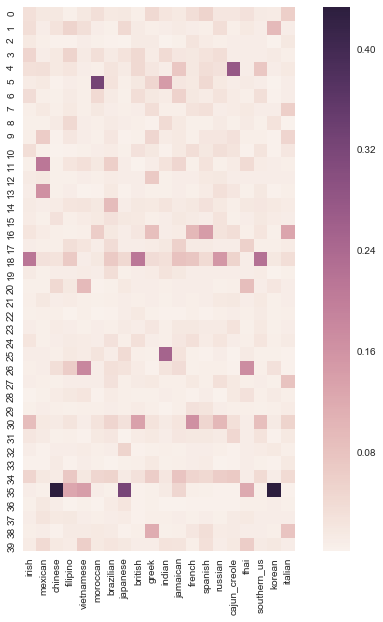

In [82]:
# Визуализируем матрицу
plot_matrix(tc_matrix)

Чем темнее квадрат в матрице, тем больше связь этой темы с данной кухней. Мы видим, что у нас есть темы, которые связаны с несколькими кухнями. Такие темы показывают набор ингредиентов, которые популярны в кухнях нескольких народов, то есть указывают на схожесть кухонь этих народов. Некоторые темы распределены по всем кухням равномерно, они показывают наборы продуктов, которые часто используются в кулинарии всех стран. 

Жаль, что в датасете нет названий рецептов, иначе темы было бы проще интерпретировать...

### Заключение
Мы построили несколько моделей LDA, посмотрели, на что влияют гиперпараметры модели и как можно использовать построенную модель. 